<a href="https://www.kaggle.com/code/velimirkovacic/mn-0036533917-ferules?scriptVersionId=183359379" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Feature engineering, rules-based models and ensembles


In [1]:
!pip install Wittgenstein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.6/110.6 kB 5.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
import shap
import wittgenstein as lw
from IPython.display import display


First we will import the train dataset created in the first notebook. 

In [3]:

df_train = pd.read_csv("../input/train-set-za-biljeznicu-2/train2.csv")
df_train['Date'] = pd.to_datetime(df_train['Date'])

df_test = pd.read_csv("../input/dapprojekt24-1/test.csv")



## 1. Cross-validation Function

The cross-validation function uses a five-fold cross-validation. The function takes a dataset (X y), splits it into 5 folds, tests 5 classifiers with default parameters and prints a table showing f1-scores. The calssifiers are: GaussianNB, LogisticRegression, RandomForestClassifier, ExtraTreesClassifier and XGBClassifier. 

In [4]:
def test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return f1_score(y_test, y_pred)


def cross_val_5fold(X, y):
    models = [
    (GaussianNB(), "GaussianNB"),
    (LogisticRegression(), "LogisticRegression"),
    (RandomForestClassifier(), "RandomForestClassifier"),
    (ExtraTreesClassifier(), "ExtraTreesClassifier"),
    (XGBClassifier(), "XGBClassifier")
    ]

    data = {
            'Algorithm': [],
            'Fold 1': [],
            'Fold 2': [],
            'Fold 3': [],
            'Fold 4': [],
            'Fold 5': [],
            'Average': []
        }
    df = pd.DataFrame(data)


    for model, name in models: 
        print("Model:", name)
        five_folds = KFold(n_splits=5, shuffle=True)
        row = [name]
        i = 1
        for train, test in five_folds.split(X):
            X_train = X.iloc[train]
            X_test = X.iloc[test]
            y_train = y.iloc[train]
            y_test = y.iloc[test] 
            print("Fold", i)
            i+=1
            f1 = test_model(model, X_train, X_test, y_train, y_test)
            row += [f1]
        
        row += [np.average(row[1:])]
        df.loc[len(df)] = row
    print(df)



### Running the cross-validation function
We will use the five-fold cross-validation function on the default dataset.

In [5]:
X = df_train.drop(columns=["Date", "Symbol", "Id", "Target"])
y = df_train["Target"]
cross_val_5fold(X, y)

Model: GaussianNB
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: LogisticRegression
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: RandomForestClassifier
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: ExtraTreesClassifier
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: XGBClassifier
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
                Algorithm    Fold 1    Fold 2    Fold 3    Fold 4    Fold 5  \
0              GaussianNB  0.876817  0.876535  0.876339  0.874046  0.876024   
1      LogisticRegression  0.877254  0.877492  0.878394  0.877883  0.876361   
2  RandomForestClassifier  0.881674  0.882489  0.883404  0.882708  0.881819   
3    ExtraTreesClassifier  0.882208  0.883017  0.881846  0.883645  0.880887   
4           XGBClassifier  0.879155  0.879986  0.879413  0.876919  0.879004   

    Average  
0  0.875952  
1  0.877477  
2  0.882419  
3  0.882321  
4  0.878895  


### Submitting to Competition
The Random Forest Classifier has achieved the highest F1 score and we will thus submit it to competition as per the instructions. NaN values in the test set have been resolved using mean-fill.

In [6]:
X_test = df_test.drop(columns=["Date", "Symbol", "Id"])
X_test = X_test.fillna(X_test.mean())
model = RandomForestClassifier()
model.fit(X, y)
y_test = model.predict(X_test)
submission = df_test.loc[:,df_test.columns.isin(('Id', ))]
submission.loc[:,'Target'] = y_test
submission.to_csv("submission_1.csv", index=None)
submission


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Id,Target
0,0,0
1,1,0
2,2,1
3,3,0
4,4,1
...,...,...
209595,209595,1
209596,209596,1
209597,209597,1
209598,209598,1


## 2. New Features
### 2.1 Domain specific features
#### 2.1.1 Simple Moving Average SMA
SMA is calculated as the average closing price of the stock last N days. We will use N = 200 as it is the most commomn within trading circles. The 199 NaNs per stock will be filled with the Close values.

In [7]:
df_train['SMA'] = df_train.groupby('Symbol')['Close'].rolling(window=200).mean().reset_index(0, drop=True)
df_train.loc[df_train['SMA'].isna(), 'SMA'] = df_train['Close']


#### 2.1.2 Exponential Moving Average (EMA)
Unlike SMA, EMA places greater importance on more recent values. It is a weighted average. We will use a 12 day span.

In [8]:
df_train['EMA'] = df_train.groupby('Symbol')['Close'].apply(lambda x: x.ewm(span=12, adjust=False).mean()).reset_index(0, drop=True)

#### 2.1.3 Moving Average Convergence Divergence (MACD)
MACD is the difference between a 12 day span EMA and a 26 day span EMA. 

In [9]:
df_train['MACD'] = df_train['EMA'] - df_train.groupby('Symbol')['Close'].apply(lambda x: x.ewm(span=26, adjust=False).mean()).reset_index(0, drop=True)

#### 2.1.4 Relative Strength Index (RSI)
RSI is a an indicator within range of 0 to 100 and is calculated as: 
$RSI = 100 - \frac{100}{1 + \frac{AvgGain}{AvgLoss}}.$ We will use a 14 day span.

The missing values will be filled with the mean value of that stock. We will do this for all other instances of this issue.



In [10]:
change = df_train.groupby('Symbol')['Close'].diff()

df_train['Gain'] = change.apply(lambda x: x if x > 0 else 0)
df_train['Loss'] = change.apply(lambda x: -x if x < 0 else 0)

avgGain = df_train.groupby('Symbol')['Gain'].rolling(window=14, min_periods=1).mean().reset_index(drop=True)
avgLoss = df_train.groupby('Symbol')['Loss'].rolling(window=14, min_periods=1).mean().reset_index(drop=True)


df_train['RSI'] = 100 - (100 / (1 + avgGain/avgLoss))
df_train.loc[df_train['Loss'] < 1e-2, 'RSI'] = 100
df_train["RSI"] = df_train.groupby('Symbol')['RSI'].transform(lambda x: x.fillna(x.mean()))
df_train = df_train.drop(columns=['Gain', 'Loss'])

#### 2.1.5 On-Balance Volume (OBV)
OBV is calculated as:

$
OBV_i = OBV_{i -1} \begin{cases} 
Volume_i & \text{if } Close_i > Close_{i-1} \\
0 & \text{if } Close_i = Close_{i-1} \\
-Volume_i & \text{if } Close_i < Close_{i-1} 
\end{cases}
$

In [11]:
df_train['Dir'] = change.apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df_train['OBV'] = df_train.groupby('Symbol')['Volume'].transform(lambda x: x * df_train['Dir']).cumsum()

df_train = df_train.drop(columns=['Dir'])

In [12]:
df_train

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id,SMA,EMA,MACD,RSI,OBV
0,2010-01-04,MMM,53.295380,83.019997,83.449997,82.669998,83.089996,3043700.0,0,0,83.019997,83.019997,0.000000,100.000000,0.000000e+00
1,2010-01-05,MMM,52.961575,82.500000,83.230003,81.699997,82.800003,2847000.0,0,1,82.500000,82.939997,-0.041481,0.000000,-2.847000e+06
2,2010-01-06,MMM,53.712681,83.669998,84.599998,83.510002,83.879997,5268500.0,0,2,83.669998,83.052305,0.019825,100.000000,2.421500e+06
3,2010-01-07,MMM,53.751179,83.730003,83.760002,82.120003,83.320000,4470100.0,0,3,83.730003,83.156566,0.072418,100.000000,6.891600e+06
4,2010-01-08,MMM,54.129955,84.320000,84.320000,83.300003,83.690002,3405800.0,0,4,84.320000,83.335556,0.159863,100.000000,1.029740e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474166,2019-12-24,ZTS,131.227859,132.919998,133.080002,131.289993,132.210007,442500.0,1,501395,115.112650,127.882202,2.712151,100.000000,1.010496e+11
474167,2019-12-26,ZTS,131.336456,133.029999,133.190002,132.320007,133.190002,929400.0,1,501396,115.293150,128.674170,2.921901,100.000000,1.010506e+11
474168,2019-12-27,ZTS,131.553665,133.250000,133.479996,132.380005,133.399994,1296100.0,1,501397,115.478400,129.378144,3.070488,100.000000,1.010519e+11
474169,2019-12-30,ZTS,130.526886,132.210007,133.660004,131.809998,133.570007,942000.0,1,501398,115.654900,129.813815,3.068948,89.496454,1.010509e+11


### 2.2 History related features


Here we will invent new history related features that may help in our predictions.

### 2.2.1 Close Entropy (CE)
We will calculate entropy of closing prices. We will use a 10 day span. Missing entropies will be filled by the mean of the specific stock.

In [13]:
probs = df_train.groupby('Symbol')['Close'].transform(lambda x: x / x.sum())

df_train["CE"] = probs.rolling(window=10).apply(lambda x: -np.sum(x * np.log2(x))).reset_index(drop=True)
df_train["CE"] = df_train.groupby('Symbol')['CE'].transform(lambda x: x.fillna(x.mean()))

### 2.2.2 Average Open-Close (AOC)
This will be the average value of Open - Close. We will use a 20 day span.

In [14]:
open_mean = df_train.groupby('Symbol')['Open'].rolling(window=20).mean().reset_index(drop=True)
close_mean = df_train.groupby('Symbol')['Close'].rolling(window=20).mean().reset_index(drop=True)

df_train["AOC"] = open_mean - close_mean
df_train["AOC"] = df_train.groupby('Symbol')['AOC'].transform(lambda x: x.fillna(x.mean()))

### 2.2.3 Close Variance (CV)
This will be the variance of Close. We will use a 30 day span.


In [15]:
df_train["CV"] = df_train.groupby('Symbol')["Close"].rolling(window=30).var().reset_index(drop=True)
df_train["CV"] = df_train.groupby('Symbol')["CV"].transform(lambda x: x.fillna(x.mean()))

### 2.2.4 Mean Volume (MV)
This will be the mean of Volume. We will use a 15 day span.


In [16]:
df_train["MV"] = df_train.groupby('Symbol')["Volume"].rolling(window=15).mean().reset_index(drop=True)
df_train["MV"] = df_train.groupby('Symbol')["MV"].transform(lambda x: x.fillna(x.mean()))

### 2.2.5 Volume Variance (VV)
This is the variance of Volume. We will use a 30 day span.

In [17]:
df_train["VV"] = df_train.groupby('Symbol')["Volume"].rolling(window=30).var().reset_index(drop=True)
df_train["VV"] = df_train.groupby('Symbol')["VV"].transform(lambda x: x.fillna(x.mean()))

### 2.2.6 Average High-Low (AHL)
This will be the average value of High - Low. We will use a 20 day span.

In [18]:
high_mean = df_train.groupby('Symbol')['High'].rolling(window=20).mean().reset_index(drop=True)
low_mean = df_train.groupby('Symbol')['Low'].rolling(window=20).mean().reset_index(drop=True)

df_train["AHL"] = high_mean - low_mean
df_train["AHL"] = df_train.groupby('Symbol')['AHL'].transform(lambda x: x.fillna(x.mean()))

### 2.2.7 High Variance (HV)
This is the variance of High. We will use a 20 day span.

In [19]:
df_train["HV"] = df_train.groupby('Symbol')['High'].rolling(window=20).var().reset_index(drop=True)
df_train["HV"] = df_train.groupby('Symbol')['HV'].transform(lambda x: x.fillna(x.mean()))

### 2.2.8 Low Variance (LV)
This is the variance of Low. We will use a 20 day span.

In [20]:
df_train["LV"] = df_train.groupby('Symbol')['Low'].rolling(window=20).var().reset_index(drop=True)
df_train["LV"] = df_train.groupby('Symbol')['LV'].transform(lambda x: x.fillna(x.mean()))

### 2.2.9 Volume Entropy (VE)
This is the entropy of Volume. We will use a 10 day span.

In [21]:
probs = df_train.groupby('Symbol')['Volume'].transform(lambda x: x / x.sum())

df_train["VE"] = probs.rolling(window=10).apply(lambda x: -np.sum(x/np.sum(x) * np.log2(x/np.sum(x)))).reset_index(drop=True)
df_train["VE"] = df_train.groupby('Symbol')['VE'].transform(lambda x: x.fillna(x.mean()))

### 2.2.10 Open Entropy (OE)
This is the entropy of Open. We will use a 10 day span.

In [22]:
probs = df_train.groupby('Symbol')['Open'].transform(lambda x: x / x.sum())

df_train["OE"] = probs.rolling(window=10).apply(lambda x: -np.sum(x/np.sum(x) * np.log2(x/np.sum(x)))).reset_index(drop=True)
df_train["OE"] = df_train.groupby('Symbol')['OE'].transform(lambda x: x.fillna(x.mean()))

In [23]:
df_train

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id,...,CE,AOC,CV,MV,VV,AHL,HV,LV,VE,OE
0,2010-01-04,MMM,53.295380,83.019997,83.449997,82.669998,83.089996,3043700.0,0,0,...,0.044735,-0.010517,2.329259,3.419589e+06,2.749234e+12,0.841072,1.509042,1.654129,3.262809,3.321765
1,2010-01-05,MMM,52.961575,82.500000,83.230003,81.699997,82.800003,2847000.0,0,1,...,0.044735,-0.010517,2.329259,3.419589e+06,2.749234e+12,0.841072,1.509042,1.654129,3.262809,3.321765
2,2010-01-06,MMM,53.712681,83.669998,84.599998,83.510002,83.879997,5268500.0,0,2,...,0.044735,-0.010517,2.329259,3.419589e+06,2.749234e+12,0.841072,1.509042,1.654129,3.262809,3.321765
3,2010-01-07,MMM,53.751179,83.730003,83.760002,82.120003,83.320000,4470100.0,0,3,...,0.044735,-0.010517,2.329259,3.419589e+06,2.749234e+12,0.841072,1.509042,1.654129,3.262809,3.321765
4,2010-01-08,MMM,54.129955,84.320000,84.320000,83.300003,83.690002,3405800.0,0,4,...,0.044735,-0.010517,2.329259,3.419589e+06,2.749234e+12,0.841072,1.509042,1.654129,3.262809,3.321765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474166,2019-12-24,ZTS,131.227859,132.919998,133.080002,131.289993,132.210007,442500.0,1,501395,...,0.119094,-0.423498,21.130307,2.127227e+06,8.145555e+11,1.837501,18.013597,16.495758,3.092527,3.321464
474167,2019-12-26,ZTS,131.336456,133.029999,133.190002,132.320007,133.190002,929400.0,1,501396,...,0.119843,-0.366498,23.631264,2.018087e+06,8.651257e+11,1.793501,20.652378,19.984313,3.056426,3.321424
474168,2019-12-27,ZTS,131.553665,133.250000,133.479996,132.380005,133.399994,1296100.0,1,501397,...,0.120549,-0.384499,25.348339,1.919753e+06,8.832135e+11,1.749501,23.210673,23.034585,3.037192,3.321439
474169,2019-12-30,ZTS,130.526886,132.210007,133.660004,131.809998,133.570007,942000.0,1,501398,...,0.121163,-0.354999,25.696162,1.823407e+06,9.263036e+11,1.756001,24.807829,24.574448,3.025657,3.321516


### Normalization

We will create a new dataset with the 15 new features and then normalize them with Min-Max normalization.

In [24]:
df = df_train.drop(columns=["Open", "High", "Low", "Close", "Adj Close", "Id", "Date", "Volume"])

for i in df.columns:
    if i == 'Symbol':
        continue
    df[i] = df.groupby('Symbol')[i].transform(lambda x: ((x - x.min() )/ (x.max() - x.min()))).reset_index(drop=True)

df = df.drop(columns=['Symbol'])

In [25]:
df

,Target,SMA,EMA,MACD,RSI,OBV,CE,AOC,CV,MV,VV,AHL,HV,LV,VE,OE
0,0.0,0.055388,0.050916,0.629640,1.000000,0.162438,0.411207,0.504970,0.094291,0.238391,0.115948,0.298412,0.069933,0.077773,0.922142,0.951700
1,0.0,0.051910,0.050461,0.626984,0.000000,0.155180,0.411207,0.504970,0.094291,0.238391,0.115948,0.298412,0.069933,0.077773,0.922142,0.951700
2,0.0,0.059736,0.051100,0.630909,1.000000,0.168611,0.411207,0.504970,0.094291,0.238391,0.115948,0.298412,0.069933,0.077773,0.922142,0.951700
3,0.0,0.060138,0.051694,0.634276,1.000000,0.180008,0.411207,0.504970,0.094291,0.238391,0.115948,0.298412,0.069933,0.077773,0.922142,0.951700
4,0.0,0.064085,0.052713,0.639874,1.000000,0.188690,0.411207,0.504970,0.094291,0.238391,0.115948,0.298412,0.069933,0.077773,0.922142,0.951700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474166,1.0,0.991749,0.977097,0.899051,1.000000,0.991833,0.971485,0.094497,0.799234,0.063408,0.004799,0.650734,0.725616,0.670844,0.913720,0.996008
474167,1.0,0.993832,0.984910,0.934832,1.000000,0.994980,0.979917,0.130768,0.894072,0.057805,0.005157,0.632038,0.832027,0.812981,0.899504,0.995658
474168,1.0,0.995969,0.991854,0.960180,1.000000,0.999368,0.987854,0.119314,0.959185,0.052757,0.005286,0.613342,0.935193,0.937260,0.891930,0.995789
474169,1.0,0.998005,0.996151,0.959917,0.877245,0.996179,0.994763,0.138086,0.972374,0.047811,0.005591,0.616104,0.999600,1.000000,0.887387,0.996456


### Running the Cross-Validation Function

We will find which model yields the highest F1 Score.

In [26]:
X = df.drop(columns=["Target"])
y = df["Target"]
cross_val_5fold(X, y)

Model: GaussianNB
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: LogisticRegression
Fold 1


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fold 2


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fold 3


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fold 4
Fold 5


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model: RandomForestClassifier
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: ExtraTreesClassifier
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: XGBClassifier
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
                Algorithm    Fold 1    Fold 2    Fold 3    Fold 4    Fold 5  \
0              GaussianNB  0.838777  0.840528  0.839082  0.837342  0.839240   
1      LogisticRegression  0.876691  0.878265  0.878354  0.877390  0.876934   
2  RandomForestClassifier  0.948672  0.948997  0.947419  0.948623  0.946781   
3    ExtraTreesClassifier  0.961128  0.961809  0.959929  0.959192  0.958933   
4           XGBClassifier  0.889999  0.891884  0.890333  0.890418  0.889695   

    Average  
0  0.838994  
1  0.877527  
2  0.948098  
3  0.960198  
4  0.890466  


Extra Trees Classifier has yielded the best F1 score. We will train the model and send it to competition.

### Submitting to Competition
We will have to create all the features for the test set and then normalize them.

In [27]:
df_test['SMA'] = df_test.groupby('Symbol')['Close'].rolling(window=200).mean().reset_index(0, drop=True)
df_test.loc[df_test['SMA'].isna(), 'SMA'] = df_test['Close']
df_test['EMA'] = df_test.groupby('Symbol')['Close'].apply(lambda x: x.ewm(span=12, adjust=False).mean()).reset_index(0, drop=True)
df_test['MACD'] = df_test['EMA'] - df_test.groupby('Symbol')['Close'].apply(lambda x: x.ewm(span=26, adjust=False).mean()).reset_index(0, drop=True)
change = df_test.groupby('Symbol')['Close'].diff()
df_test['Gain'] = change.apply(lambda x: x if x > 0 else 0)
df_test['Loss'] = change.apply(lambda x: -x if x < 0 else 0)
avgGain = df_test.groupby('Symbol')['Gain'].rolling(window=14, min_periods=1).mean().reset_index(drop=True)
avgLoss = df_test.groupby('Symbol')['Loss'].rolling(window=14, min_periods=1).mean().reset_index(drop=True)
df_test['RSI'] = 100 - (100 / (1 + avgGain/avgLoss))
df_test.loc[df_test['Loss'] < 1e-2, 'RSI'] = 100
df_test["RSI"] = df_test.groupby('Symbol')['RSI'].transform(lambda x: x.fillna(x.mean()))
df_test = df_test.drop(columns=['Gain', 'Loss'])
df_test['Dir'] = change.apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df_test['OBV'] = df_test.groupby('Symbol')['Volume'].transform(lambda x: x * df_test['Dir']).cumsum()
df_test = df_test.drop(columns=['Dir'])
probs = df_test.groupby('Symbol')['Close'].transform(lambda x: x / x.sum())
df_test["CE"] = probs.rolling(window=10).apply(lambda x: -np.sum(x * np.log2(x))).reset_index(drop=True)
df_test["CE"] = df_test.groupby('Symbol')['CE'].transform(lambda x: x.fillna(x.mean()))
open_mean = df_test.groupby('Symbol')['Open'].rolling(window=20).mean().reset_index(drop=True)
close_mean = df_test.groupby('Symbol')['Close'].rolling(window=20).mean().reset_index(drop=True)
df_test["AOC"] = open_mean - close_mean
df_test["AOC"] = df_test.groupby('Symbol')['AOC'].transform(lambda x: x.fillna(x.mean()))
df_test["CV"] = df_test.groupby('Symbol')["Close"].rolling(window=30).var().reset_index(drop=True)
df_test["CV"] = df_test.groupby('Symbol')["CV"].transform(lambda x: x.fillna(x.mean()))
df_test["MV"] = df_test.groupby('Symbol')["Volume"].rolling(window=15).mean().reset_index(drop=True)
df_test["MV"] = df_test.groupby('Symbol')["MV"].transform(lambda x: x.fillna(x.mean()))
df_test["VV"] = df_test.groupby('Symbol')["Volume"].rolling(window=30).var().reset_index(drop=True)
df_test["VV"] = df_test.groupby('Symbol')["VV"].transform(lambda x: x.fillna(x.mean()))
high_mean = df_test.groupby('Symbol')['High'].rolling(window=20).mean().reset_index(drop=True)
low_mean = df_test.groupby('Symbol')['Low'].rolling(window=20).mean().reset_index(drop=True)
df_test["AHL"] = high_mean - low_mean
df_test["AHL"] = df_test.groupby('Symbol')['AHL'].transform(lambda x: x.fillna(x.mean()))
df_test["HV"] = df_test.groupby('Symbol')['High'].rolling(window=20).var().reset_index(drop=True)
df_test["HV"] = df_test.groupby('Symbol')['HV'].transform(lambda x: x.fillna(x.mean()))
df_test["LV"] = df_test.groupby('Symbol')['Low'].rolling(window=20).var().reset_index(drop=True)
df_test["LV"] = df_test.groupby('Symbol')['LV'].transform(lambda x: x.fillna(x.mean()))
probs = df_test.groupby('Symbol')['Volume'].transform(lambda x: x / x.sum())
df_test["VE"] = probs.rolling(window=10).apply(lambda x: -np.sum(x/np.sum(x) * np.log2(x/np.sum(x)))).reset_index(drop=True)
df_test["VE"] = df_test.groupby('Symbol')['VE'].transform(lambda x: x.fillna(x.mean()))
probs = df_test.groupby('Symbol')['Open'].transform(lambda x: x / x.sum())
df_test["OE"] = probs.rolling(window=10).apply(lambda x: -np.sum(x/np.sum(x) * np.log2(x/np.sum(x)))).reset_index(drop=True)
df_test["OE"] = df_test.groupby('Symbol')['OE'].transform(lambda x: x.fillna(x.mean()))


In [28]:
df_test = df_test.drop(columns=["Open", "High", "Low", "Close", "Adj Close", "Date", "Volume"])

for i in df_test.columns:
    if i == 'Symbol' or i == 'Id':
        continue
    df_test[i] = df_test.groupby('Symbol')[i].transform(lambda x: ((x - x.min() )/ (x.max() - x.min()))).reset_index(drop=True)

df_test = df_test.drop(columns=['Symbol'])

In [29]:
X_test = df_test.drop(columns=['Id'])
X_test = X_test.fillna(X_test.mean())
model = ExtraTreesClassifier()
model.fit(X, y)
y_test = model.predict(X_test)
submission = df_test.loc[:,df_test.columns.isin(('Id', ))]
submission.loc[:,'Target'] = y_test
submission.to_csv("submission_2.csv", index=None)
submission


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Id,Target
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
...,...,...
209595,209595,1.0
209596,209596,1.0
209597,209597,1.0
209598,209598,1.0


## 3. Wrapper Method
By training a Linear SVC we will see which features contribute more and which feature contribute less to the F1 score.
We will train using 14 features, remove the least contributing one, then 13 features unitl and so on we are left with only 12 features.

In [30]:
def wrapper(X, y):
    model = LinearSVC()
    print("Column", "F1 Score")
    for column in X.columns:
        X_wrapper = X.drop(columns=[column])
        model.fit(X_wrapper, y)
        y_pred = model.predict(X_wrapper)
        f1 = f1_score(y, y_pred)
        print(column, f1)

In [31]:
X = df.drop(columns=["Target"])
y = df["Target"]
wrapper(X, y)

Column F1 Score
SMA 0.8774854583375749
EMA 0.8774772706020495
MACD 0.8774838395806872
RSI 0.8774820522836361
OBV 0.877482342329759
CE 0.8774772706020495
AOC 0.8774896130490878
CV 0.8774916904195984
MV 0.8774916904195984
VV 0.8774927291085419
AHL 0.8774875356884136
HV 0.8774916904195984
LV 0.8774916904195984
VE 0.8774937677999446
OE 0.8774814251911929


The feature without which the score is highest is Volume Entropy (VE), we will remove it.

In [32]:
X = X.drop(columns=["VE"])
wrapper(X, y)

Column F1 Score
SMA 0.8774885743675214
EMA 0.8774772706020495
MACD 0.8774859169350705
RSI 0.8774830909525647
OBV 0.877484419665844
CE 0.8774772706020495
AOC 0.8774916904195984
CV 0.8774937677999446
MV 0.8774937677999446
VV 0.8774911103640608
AHL 0.8774906517331137
HV 0.8774937677999446
LV 0.8774937677999446
OE 0.877482463844626


Removing LV, HV, MV and CV yields the same F1 score. We will remove LV.

In [33]:
X = X.drop(columns=["LV"])
wrapper(X, y)

Column F1 Score
SMA 0.8774885743675214
EMA 0.8774772706020495
MACD 0.8774859169350705
RSI 0.8774830909525647
OBV 0.877484419665844
CE 0.8774772706020495
AOC 0.8774916904195984
CV 0.8774937677999446
MV 0.8774937677999446
VV 0.8774924390835755
AHL 0.8774906517331137
HV 0.8774937677999446
OE 0.877482463844626


MV, HV and CV have the same F1 score, we will now remove MV.

In [34]:
X = X.drop(columns=["MV"])
X

,SMA,EMA,MACD,RSI,OBV,CE,AOC,CV,VV,AHL,HV,OE
0,0.055388,0.050916,0.629640,1.000000,0.162438,0.411207,0.504970,0.094291,0.115948,0.298412,0.069933,0.951700
1,0.051910,0.050461,0.626984,0.000000,0.155180,0.411207,0.504970,0.094291,0.115948,0.298412,0.069933,0.951700
2,0.059736,0.051100,0.630909,1.000000,0.168611,0.411207,0.504970,0.094291,0.115948,0.298412,0.069933,0.951700
3,0.060138,0.051694,0.634276,1.000000,0.180008,0.411207,0.504970,0.094291,0.115948,0.298412,0.069933,0.951700
4,0.064085,0.052713,0.639874,1.000000,0.188690,0.411207,0.504970,0.094291,0.115948,0.298412,0.069933,0.951700
...,...,...,...,...,...,...,...,...,...,...,...,...
474166,0.991749,0.977097,0.899051,1.000000,0.991833,0.971485,0.094497,0.799234,0.004799,0.650734,0.725616,0.996008
474167,0.993832,0.984910,0.934832,1.000000,0.994980,0.979917,0.130768,0.894072,0.005157,0.632038,0.832027,0.995658
474168,0.995969,0.991854,0.960180,1.000000,0.999368,0.987854,0.119314,0.959185,0.005286,0.613342,0.935193,0.995789
474169,0.998005,0.996151,0.959917,0.877245,0.996179,0.994763,0.138086,0.972374,0.005591,0.616104,0.999600,0.996456


We are now left with 12 features.

### Running the Cross-Validation Function

In [35]:
cross_val_5fold(X, y)

Model: GaussianNB
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: LogisticRegression
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: RandomForestClassifier
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: ExtraTreesClassifier
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: XGBClassifier
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
                Algorithm    Fold 1    Fold 2    Fold 3    Fold 4    Fold 5  \
0              GaussianNB  0.840947  0.842619  0.840228  0.841225  0.838369   
1      LogisticRegression  0.877639  0.877046  0.877400  0.878510  0.876999   
2  RandomForestClassifier  0.952344  0.949950  0.952621  0.950117  0.953560   
3    ExtraTreesClassifier  0.960291  0.961151  0.960272  0.960105  0.960864   
4           XGBClassifier  0.889692  0.890913  0.891228  0.889901  0.889767   

    Average  
0  0.840678  
1  0.877519  
2  0.951718  
3  0.960537  
4  0.890300  


ExtraTreesClassifier has once again proved to be the best for this.

### Submitting to Competition

In [36]:
X_test = df_test.drop(columns=['VE', 'LV', 'MV', 'Id'])
X_test = X_test.fillna(X_test.mean())
model = ExtraTreesClassifier()
model.fit(X, y)
y_test = model.predict(X_test)
submission = df_test.loc[:,df_test.columns.isin(('Id', ))]
submission.loc[:,'Target'] = y_test
submission.to_csv("submission.csv", index=None)
submission


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Id,Target
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
...,...,...
209595,209595,1.0
209596,209596,1.0
209597,209597,1.0
209598,209598,1.0


## 4. Explainability with SHAP

In [37]:
explainer = shap.TreeExplainer(model)
explainer

We will chose 10 rows of which the last 5 is all with Target equal to 1 and the first 5 with at least one with Target equal to 0 

In [38]:
selected = X.iloc[161312:161322]
print(df_train.iloc[161312:161322]["Target"])
selected

161312    0
161313    0
161314    0
161315    1
161316    1
161317    1
161318    1
161319    1
161320    1
161321    1
Name: Target, dtype: int64


,SMA,EMA,MACD,RSI,OBV,CE,AOC,CV,VV,AHL,HV,OE
161312,0.114820,0.132900,0.460706,1.000000,0.175684,0.101328,0.322554,0.694722,0.086244,0.533261,0.385846,0.999709
161313,0.115193,0.131788,0.447369,0.583035,0.168554,0.099648,0.410448,0.639731,0.084759,0.492912,0.352471,0.999727
161314,0.115533,0.130744,0.435667,0.511053,0.163184,0.098390,0.461857,0.585720,0.084662,0.483097,0.312275,0.999816
161315,0.115863,0.128661,0.414994,0.584821,0.152899,0.096494,0.414594,0.535701,0.084175,0.495638,0.249229,0.999820
161316,0.116219,0.126591,0.395966,0.387476,0.147207,0.094614,0.436982,0.476743,0.082588,0.494002,0.196633,0.999841
161317,0.116569,0.124428,0.377471,0.232843,0.140766,0.093206,0.443615,0.406406,0.083865,0.494002,0.126583,0.999770
161318,0.116914,0.122872,0.366095,1.000000,0.148808,0.092109,0.517413,0.352620,0.083657,0.452563,0.121583,0.999748
161319,0.117248,0.121315,0.355559,0.360000,0.143375,0.091191,0.477612,0.302835,0.083238,0.468376,0.095204,0.999742
161320,0.117558,0.119553,0.343853,0.317647,0.139121,0.089946,0.590382,0.253436,0.082274,0.432389,0.096562,0.999699
161321,0.117877,0.118336,0.338179,1.000000,0.146108,0.088864,0.548922,0.205905,0.082812,0.398583,0.100231,0.999667


We will extract the shap values and create a force_plot from these 10 samples.

In [39]:
shap_values = []
for i in range(len(selected)):
    shap_values += [explainer.shap_values(selected.iloc[i])]


### Force Plots

In [40]:
shap.initjs()
for value in shap_values:
    display(shap.force_plot(explainer.expected_value[1], value[0]))

For samples with Target = 0 the most impactful feature is CV (Close Variance), followed by OBV (On-Balance Volume).
For samples with Target = 1 the most impactful feature is EMA (Exponential Moving Average), followed by MACD (Moving average Convergence/Divergence) and AHL (Average High - Low).

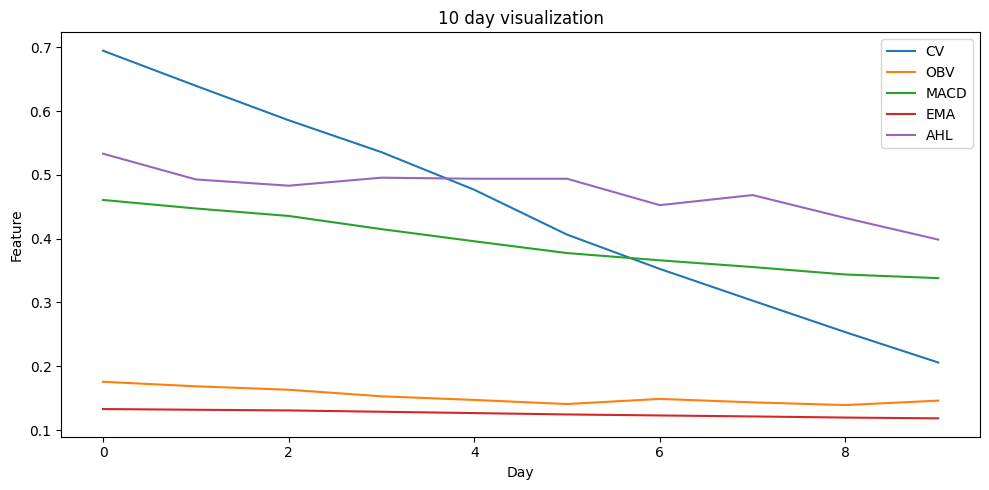

In [41]:
def visualize(series):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    for col in ["CV", "OBV", "MACD", "EMA", "AHL"]:
        ax.plot(range(len(series)), series[col], label=col)
    ax.set_title("10 day visualization")
    ax.set_xlabel("Day")
    ax.set_ylabel("Feature")
    ax.legend()

    plt.tight_layout()
    plt.show()
    
visualize(selected)

## 5. RIPPER Optimization

We will choose NVIDIA stock.

In [42]:
df_test

,Id,SMA,EMA,MACD,RSI,OBV,CE,AOC,CV,MV,VV,AHL,HV,LV,VE,OE
0,0,0.877836,0.796009,0.619749,1.000000,0.823022,0.508506,0.431750,0.191778,0.313533,0.214936,0.471661,0.172976,0.174491,0.894734,0.902489
1,1,0.861001,0.793930,0.610890,0.000000,0.815949,0.508506,0.431750,0.191778,0.313533,0.214936,0.471661,0.172976,0.174491,0.894734,0.902489
2,2,0.862847,0.792400,0.605022,1.000000,0.821678,0.508506,0.431750,0.191778,0.313533,0.214936,0.471661,0.172976,0.174491,0.894734,0.902489
3,3,0.855027,0.790139,0.596476,0.269842,0.815447,0.508506,0.431750,0.191778,0.313533,0.214936,0.471661,0.172976,0.174491,0.894734,0.902489
4,4,0.884679,0.791887,0.605651,1.000000,0.823356,0.508506,0.431750,0.191778,0.313533,0.214936,0.471661,0.172976,0.174491,0.894734,0.902489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209595,209595,0.776896,0.629352,0.645985,0.570328,0.600216,0.639757,0.158232,0.037667,0.437875,0.199300,0.295060,0.043936,0.063904,0.915404,0.984490
209596,209596,0.777510,0.637054,0.673664,1.000000,0.620613,0.641416,0.158872,0.037750,0.435372,0.195486,0.312896,0.049260,0.067256,0.899337,0.984576
209597,209597,0.778167,0.644687,0.699021,1.000000,0.641224,0.653295,0.132223,0.044066,0.426592,0.196573,0.315608,0.056493,0.075956,0.939091,0.981078
209598,209598,0.778818,0.649234,0.710223,0.523166,0.611910,0.663590,0.104676,0.047990,0.442600,0.196418,0.290951,0.062658,0.085174,0.937329,0.979830


In [43]:
df = df_train.drop(columns=["Id", "Open", "High", "Low", "Close", "Adj Close", "Date", "Volume", "VE", "LV", "MV"])
for i in df.columns:
    if i == 'Symbol' or i == 'Id':
        continue
    df[i] = df_train.groupby('Symbol')[i].transform(lambda x: ((x - x.min() )/ (x.max() - x.min()))).reset_index(drop=True)

X = df[df_train["Symbol"] == "NVDA"]
X

,Symbol,Target,SMA,EMA,MACD,RSI,OBV,CE,AOC,CV,VV,AHL,HV,OE
313949,NVDA,0.0,0.040251,0.034097,0.679266,1.000000,0.184996,0.404511,0.442874,0.113866,0.026724,0.402724,0.097170,0.858376
313950,NVDA,0.0,0.041382,0.034252,0.679922,1.000000,0.195511,0.364858,0.442874,0.113866,0.026724,0.402724,0.097170,0.711389
313951,NVDA,0.0,0.041884,0.034452,0.680719,1.000000,0.204878,0.324669,0.442874,0.113866,0.026724,0.402724,0.097170,0.561989
313952,NVDA,0.0,0.040334,0.034408,0.680429,0.311183,0.196974,0.283968,0.442874,0.113866,0.026724,0.402724,0.097170,0.412133
313953,NVDA,0.0,0.040502,0.034395,0.680285,1.000000,0.203874,0.243868,0.442874,0.113866,0.026724,0.402724,0.097170,0.264766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316451,NVDA,1.0,0.713618,0.819664,0.925103,0.548401,0.992873,0.846885,0.535020,0.094056,0.032380,0.525499,0.113299,0.998256
316452,NVDA,1.0,0.715096,0.825393,0.931135,1.000000,0.995511,0.854164,0.532309,0.101472,0.033065,0.518847,0.123414,0.998645
316453,NVDA,1.0,0.716589,0.828911,0.927361,0.589836,0.991837,0.858420,0.559422,0.093211,0.033428,0.543238,0.134039,0.999121
316454,NVDA,1.0,0.717898,0.829277,0.910534,0.648753,0.988113,0.861195,0.579756,0.087931,0.033847,0.544821,0.136729,0.999332


In [44]:
y = X["Target"]
X = X.drop(columns=["Target", "Symbol"])
X

,SMA,EMA,MACD,RSI,OBV,CE,AOC,CV,VV,AHL,HV,OE
313949,0.040251,0.034097,0.679266,1.000000,0.184996,0.404511,0.442874,0.113866,0.026724,0.402724,0.097170,0.858376
313950,0.041382,0.034252,0.679922,1.000000,0.195511,0.364858,0.442874,0.113866,0.026724,0.402724,0.097170,0.711389
313951,0.041884,0.034452,0.680719,1.000000,0.204878,0.324669,0.442874,0.113866,0.026724,0.402724,0.097170,0.561989
313952,0.040334,0.034408,0.680429,0.311183,0.196974,0.283968,0.442874,0.113866,0.026724,0.402724,0.097170,0.412133
313953,0.040502,0.034395,0.680285,1.000000,0.203874,0.243868,0.442874,0.113866,0.026724,0.402724,0.097170,0.264766
...,...,...,...,...,...,...,...,...,...,...,...,...
316451,0.713618,0.819664,0.925103,0.548401,0.992873,0.846885,0.535020,0.094056,0.032380,0.525499,0.113299,0.998256
316452,0.715096,0.825393,0.931135,1.000000,0.995511,0.854164,0.532309,0.101472,0.033065,0.518847,0.123414,0.998645
316453,0.716589,0.828911,0.927361,0.589836,0.991837,0.858420,0.559422,0.093211,0.033428,0.543238,0.134039,0.999121
316454,0.717898,0.829277,0.910534,0.648753,0.988113,0.861195,0.579756,0.087931,0.033847,0.544821,0.136729,0.999332


We do a 67%-33% train-test split.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = lw.RIPPER()
model.fit(X_train, y_train)

We do a prediction on the test set.

In [46]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

F1 Score: 0.8027095681625742


We also print the rules of the RIPPER model.

In [47]:
for rule in model.ruleset_:
    print(rule)

[SMA=0.065-0.23]
[AOC=>0.63]
[OBV=0.15-0.18]
[VV=<0.0019^EMA=0.34-0.57]
[SMA=0.63-0.81^CE=>0.77]
[SMA=0.23-0.63^EMA=0.57-0.74]
[VV=0.015-0.025^CE=<0.018]
[AOC=0.54-0.63^EMA=0.041-0.079]
[CE=0.045-0.055^SMA=0.034-0.042]
[AHL=0.4-0.44^OBV=>0.89]
[AHL=0.56-0.65^CV=>0.25]
[MACD=0.677-0.68^OBV=<0.15]
[SMA=<0.017^MACD=0.689-0.704]
[VV=0.011-0.015^SMA=0.026-0.034]
[OE=0.9993-0.9995^HV=0.063-0.08]
[MACD=>0.824^EMA=>0.74]
[CE=0.018-0.026^SMA=0.026-0.034]
[EMA=0.033-0.041^SMA=0.042-0.065]


The rules seem to be abundant and convoluted. However it is much more interpretable than those of other models.

For example let's look at rule [OBV=0.24-0.35^EMA=0.012-0.019], it is applied when OBV is in range $[0.24, 0.35]$ and EMA is in range $[0.012, 0.019]$.

### Grid search optimization of hyperparameters
We will use grid search to find the optimal values of parameters k, prune_size and dl_allowance

In [48]:
def grid_search(max_rules=None, max_rule_conds=None):
    ks = [1, 2, 3, 4, 5]
    prune_sizes = [0.1, 0.15, 0.2, 0.25, 0.3]
    dl_allowances = [16, 32, 64, 100, 128, 180, 256]

    best_f1 = 0
    best_params = None

    print("K", "prune_size", "dl_allowance", "F1 Score")
    for k in ks:
        for prune_size in prune_sizes:
            for dl_allowance in dl_allowances:
                model = lw.RIPPER(max_rules=max_rules, max_rule_conds=max_rule_conds, k=k, prune_size=prune_size, dl_allowance=dl_allowance)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                f1 = f1_score(y_test, y_pred)

                print(k, prune_size, dl_allowance, f1)

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'k': k, 'prune_size': prune_size, 'dl_allowance': dl_allowance}
    return best_f1, best_params

In [49]:
best_f1, best_params = grid_search()

K prune_size dl_allowance F1 Score
1 0.1 16 0.8930722891566265
1 0.1 32 0.8490118577075098
1 0.1 64 0.8968133535660091
1 0.1 100 0.9155555555555555
1 0.1 128 0.9088213491475167
1 0.1 180 0.8897338403041826
1 0.1 256 0.9130752373995616
1 0.15 16 0.9078549848942599
1 0.15 32 0.8630245447347585
1 0.15 64 0.9047261815453863
1 0.15 100 0.9193548387096774
1 0.15 128 0.8999247554552295
1 0.15 180 0.8982667671439336
1 0.15 256 0.8958174904942966
1 0.2 16 0.8785769528228925
1 0.2 32 0.88871834228703
1 0.2 64 0.9012810851544838
1 0.2 100 0.881769641495042
1 0.2 128 0.8827586206896552
1 0.2 180 0.9062730627306274
1 0.2 256 0.8826219512195123
1 0.25 16 0.8342857142857142
1 0.25 32 0.8370967741935483
1 0.25 64 0.8251864125932062
1 0.25 100 0.8732394366197183
1 0.25 128 0.8755832037325038
1 0.25 180 0.8722741433021806
1 0.25 256 0.875
1 0.3 16 0.8621236133122028
1 0.3 32 0.7682926829268293
1 0.3 64 0.8846447669977081
1 0.3 100 0.901132075471698
1 0.3 128 0.8909229595728452
1 0.3 180 0.90038022813688

### Best Model Parameters


In [50]:
print(best_f1)
best_params

0.9284132841328413


{'k': 3, 'prune_size': 0.25, 'dl_allowance': 100}

### Best Model Rules

In [51]:
model = lw.RIPPER(k=best_params["k"], prune_size=best_params["prune_size"], dl_allowance=best_params["dl_allowance"])
model.fit(X_train, y_train)

In [52]:
for rule in model.ruleset_:
    print(rule)

[SMA=0.065-0.23]
[AOC=>0.63^RSI=>0.77]
[OBV=0.15-0.18^MACD=0.68-0.683]
[EMA=0.34-0.57^VV=<0.0019]
[CE=<0.018^VV=0.015-0.025]
[SMA=0.63-0.81^CE=>0.77]
[SMA=0.23-0.63^EMA=0.57-0.74]
[CE=0.045-0.055^SMA=0.034-0.042]
[AHL=0.4-0.44^OBV=>0.89]
[OBV=0.15-0.18^HV=<0.012]
[MACD=0.677-0.68^OBV=<0.15]
[AOC=0.54-0.63^EMA=0.041-0.079]
[SMA=<0.017^MACD=0.689-0.704]
[AHL=0.4-0.44^OE=0.9996-0.9998]
[AHL=0.44-0.49^HV=0.11-0.15]
[AOC=0.49-0.54^MACD=0.67-0.677]
[AHL=0.56-0.65^SMA=0.026-0.034]
[CV=0.055-0.076^EMA=0.033-0.041]
[EMA=0.34-0.57^SMA=>0.81]
[CE=>0.77^OBV=0.82-0.89^MACD=>0.824]
[HV=0.063-0.08^OE=0.9993-0.9995]
[CV=0.12-0.17^AOC=0.39-0.43]
[AOC=>0.63]
[SMA=0.034-0.042^CV=0.041-0.055]
[SMA=0.23-0.63^OE=0.9971-0.9983]
[SMA=0.026-0.034^VV=0.011-0.015]
[OBV=<0.15^HV=0.021-0.034^EMA=<0.012]
[CE=0.018-0.026^SMA=0.026-0.034]
[AHL=0.4-0.44^OBV=<0.15]
[AOC=0.54-0.63^MACD=0.689-0.704]
[EMA=0.033-0.041^OE=0.9996-0.9998]
[VV=0.0033-0.0042^AHL=0.37-0.4]
[SMA=<0.017^AHL=<0.13]
[OE=0.9993-0.9995^MACD=0.689-0.70

### Limited RIPPER
We will see what happens when we limit the number of rules to 3 and rule conditions to 2 and see what happens.


In [53]:
model = lw.RIPPER(max_rules=3, max_rule_conds=2, k=best_params["k"], prune_size=best_params["prune_size"], dl_allowance=best_params["dl_allowance"])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)
for rule in model.ruleset_:
    print(rule)

0.5241090146750524
[AOC=>0.63]
[SMA=0.065-0.23]
[OBV=0.15-0.18]


The best model's accuracy drops dramatically. We will repeat the grid search.

In [54]:
best_f1, best_params = grid_search(max_rules=3, max_rule_conds=2)

K prune_size dl_allowance F1 Score
1 0.1 16 0.5241090146750524
1 0.1 32 0.5241090146750524
1 0.1 64 0.5241090146750524
1 0.1 100 0.5241090146750524
1 0.1 128 0.5241090146750524
1 0.1 180 0.5241090146750524
1 0.1 256 0.5241090146750524
1 0.15 16 0.5241090146750524
1 0.15 32 0.48654467168998927
1 0.15 64 0.5241090146750524
1 0.15 100 0.5241090146750524
1 0.15 128 0.5241090146750524
1 0.15 180 0.5241090146750524
1 0.15 256 0.5241090146750524
1 0.2 16 0.5241090146750524
1 0.2 32 0.48654467168998927
1 0.2 64 0.5241090146750524
1 0.2 100 0.5241090146750524
1 0.2 128 0.5241090146750524
1 0.2 180 0.4989339019189766
1 0.2 256 0.5241090146750524
1 0.25 16 0.5241090146750524
1 0.25 32 0.5241090146750524
1 0.25 64 0.5241090146750524
1 0.25 100 0.5241090146750524
1 0.25 128 0.5241090146750524
1 0.25 180 0.5241090146750524
1 0.25 256 0.5241090146750524
1 0.3 16 0.5241090146750524
1 0.3 32 0.5241090146750524
1 0.3 64 0.5241090146750524
1 0.3 100 0.5241090146750524
1 0.3 128 0.5241090146750524
1 0.3 1

The grid search confirms our suspicion that there is not much that can be done with 3 rules and 2 conditions per rule.